# SPEED analysis

First we ASSEMBLE it, after that its been LABELED. Then its PACKAGED and these going into a CARTON. At last the Cartons get PALLETIZED   
It goes from Assembly (Harro Hoefliger) to Labeler (Krones) to Packaging (Schubert Verpacker) to Cartoner (Pester Umverpacker) to Palletizer (Pester)




|IP_TAG Name   |Machine|German|Desired Speed|Alarm File location|
|--------------|-------|------|-------------|-------------------| 
|36630901_SPEED|Assembly|Montage|32 used but 35|Y:\E00_Solostar\E6_Assembly_Line_6\E63_Montage\CSV|   
|36640901_SPEED|Labeler|Etikettierer|500|Y:\E00_Solostar\E6_Assembly_Line_6\E64_Etikettierer\AuditTrail|   
|36650901_SPEED|Packaging (Pacemaker!)|Kartonierer|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E65_Kartonierer\40 - Reports|   
|36680901_SPEED|Cartoner|Endverpacker (UVP)||Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\UVP|   
|36680902_SPEED|Palletizer|PAL||Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\PAL|       

In [2]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [3]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df = []
df_speed = pd.DataFrame()

for filename in os.listdir( path ):
    if filename.endswith('_SPEED.csv'):
        Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_speed = df_speed.append(df)




Tags for Machine speeds:

|IP_TAG Name   |Machine|Desired Speed|
|--------------|-------|------------|
|36630901_SPEED|Assembly|32 steps x16 lines (= 512) used but max could be 35 steps|   
|36640901_SPEED|Labeler|500 pcs / min|   
|36650901_SPEED|Packaging (Pacemaker!)|3pcs per package x 150 steps = 450/min, or 5pcs per package x 100 steps = 500/min|   
|36680901_SPEED|Cartoner|aka UVP - no speed provided|   
|36680902_SPEED|Palletizer|aka PAL - no speed provided|    

In [5]:
df_speed['Machine'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Machine'] = 'Assembly'
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Machine'] = 'Labeler'
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Machine'] = 'Packaging'
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Machine'] = 'Cartoner'
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Machine'] = 'Palletizer'


df_speed['Max_Speed'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Max_Speed'] = (32*16)
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Max_Speed'] = 500
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Max_Speed'] = 450
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Max_Speed'] = 0
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Max_Speed'] = 0



In [6]:
# convert dates to datetime format
df_speed['IP_TREND_TIME'] = pd.to_datetime(df_speed['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_speed.set_index('IP_TREND_TIME', inplace=True)

In [18]:
# convert max_speed to numeric
df_speed['Max_Speed'] = pd.to_numeric(df_speed['Max_Speed'])



(321969, 7)

In [8]:
# assembly value is multipied by 16 (lines)
df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'] = df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'].mul(16)

# Packaging value is multiplied by pcs format being used (this should be dynamic but using 3 for the timebeing)
df_speed.loc[df_speed.Machine == 'Packaging', 'IP_TREND_VALUE'] = df_speed.loc[df_speed.Machine == 'Packaging', 'IP_TREND_VALUE'].mul(3)

In [9]:
#  drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_speed_no_sunday = df_speed[(df_speed.index.dayofweek > 0) & (df_speed.index.dayofweek < 5)]

# get Mon between 06:00 and 23:59
df_mon = df_speed[df_speed.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_speed_no_sunday = df_speed_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_speed[df_speed.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_speed_no_sunday = df_speed_no_sunday.append(df_sat)

In [10]:
df_speed['IP_TREND_VALUE'][df_speed.Machine == 'Packaging']

IP_TREND_TIME
2021-08-19 20:19:08.800    312
2021-08-19 20:19:03.700    303
2021-08-19 20:18:59.600    312
2021-08-19 20:18:54.400    303
2021-08-19 20:18:49.300    288
                          ... 
2021-08-01 00:28:39.900     48
2021-08-01 00:28:34.800     24
2021-08-01 00:27:42.600      0
2021-08-01 00:17:42.700      0
2021-08-01 00:07:42.800      0
Name: IP_TREND_VALUE, Length: 96934, dtype: int64

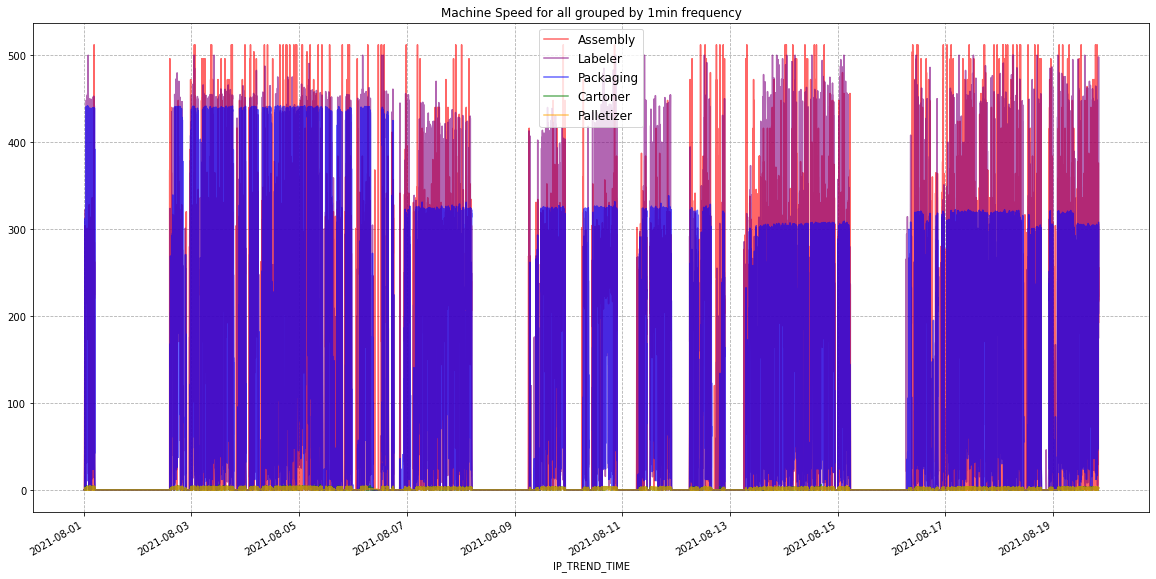

In [17]:
freq='1min'
group = df_speed.groupby(['Machine', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('IP_TREND_TIME', inplace=True)

# control the order of the machines so they match the line design
# machines = group.Machine.unique()
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')
colors = ("red", "purple", "blue", "green", "orange")

i=0

fig, axs = plt.subplots(1, 1, figsize=(20, 10))

for x in machines:
    # group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.6)
    # plt.yscale('log')
    axs.grid(True,which="both", linestyle='--')
    axs.set_title('Machine Speed for all grouped by {} frequency'.format(freq))
    i+=1

    axs.legend()

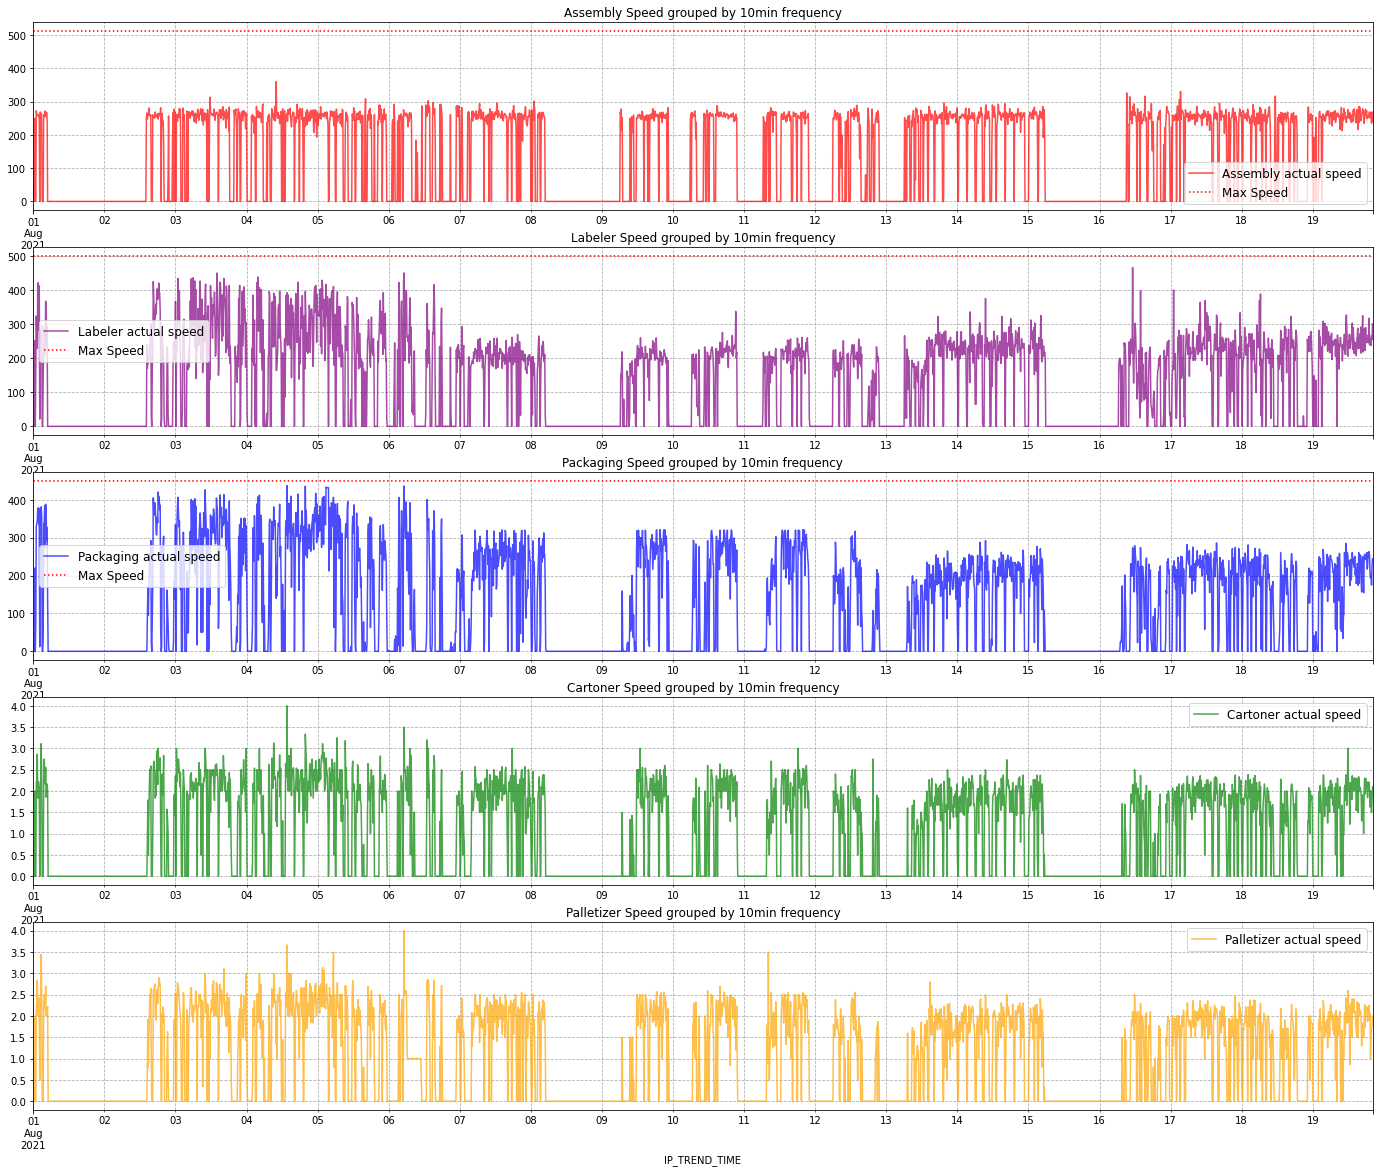

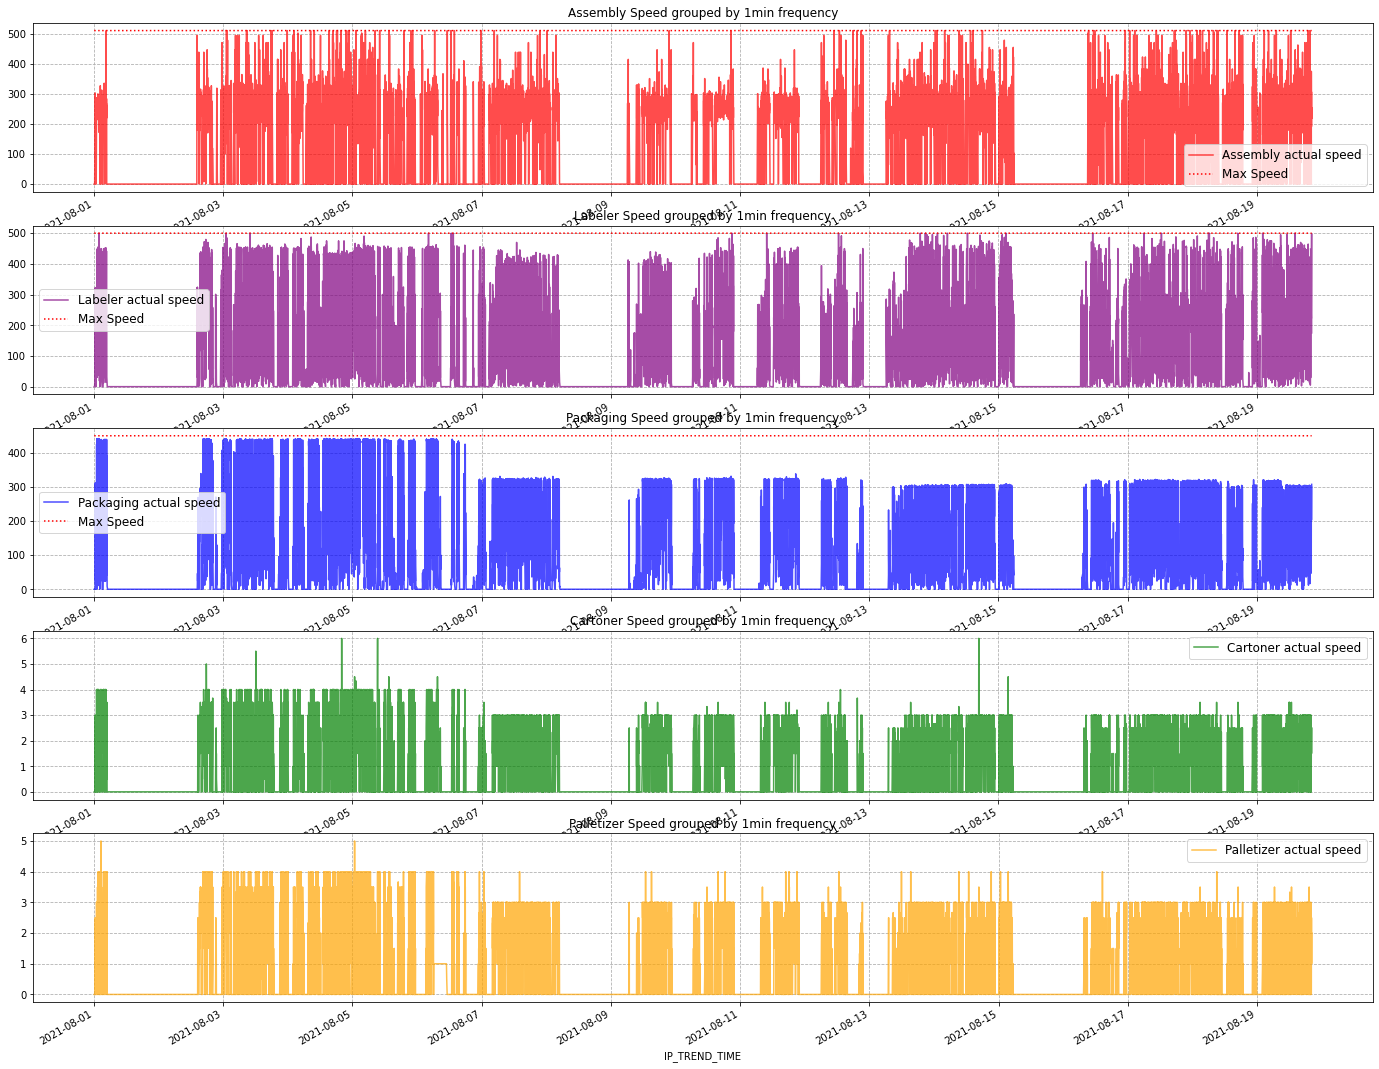

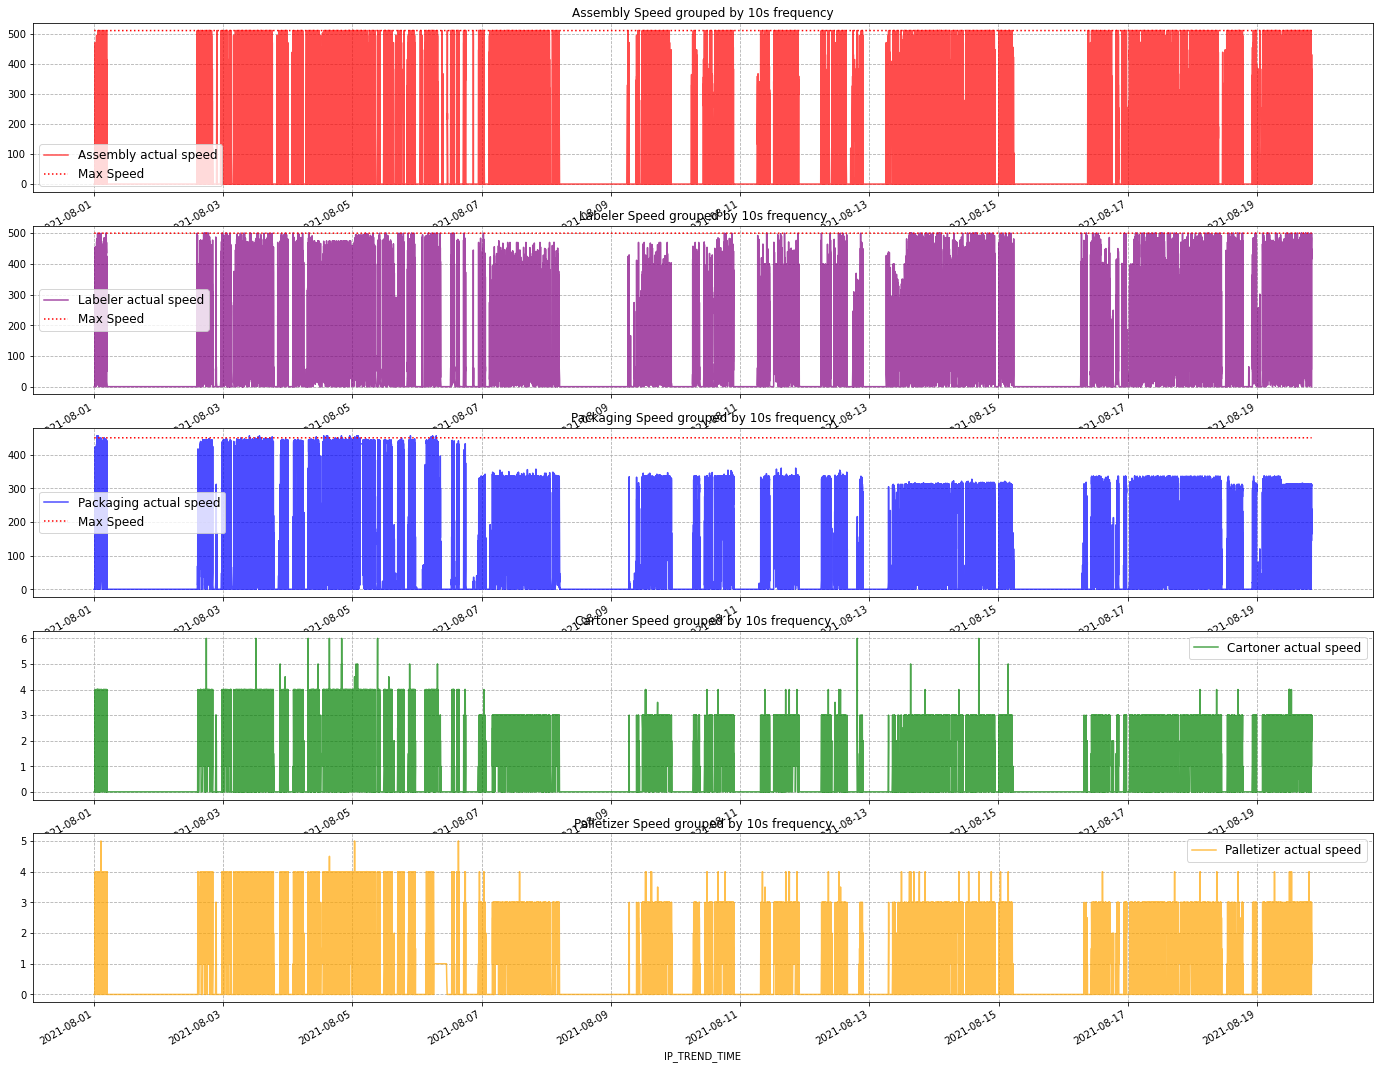

In [12]:
freq=('10min','1min','10s')

for f in freq:
    group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=f)]).mean().reset_index()
    group.set_index('IP_TREND_TIME', inplace=True)

    # machines = group.Machine.unique()
    # control the order of the machines
    machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


    fig, axs = plt.subplots(len(machines), 1, figsize=(24, 20))

    colors = ("red", "purple", "blue", "green", "orange")
    i=0

    for x in machines:
        group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i], alpha=0.7)
        # plt.yscale('log')

        if max(group['Max_Speed'][group.Machine == x]) > 0:
            group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

        axs[i].grid(True,which="both", linestyle='--')
        axs[i].set_title('{} Speed grouped by {} frequency'.format(x, f))
        plt.rc('legend', fontsize=12)    # legend fontsize
        axs[i].legend()
        i+=1

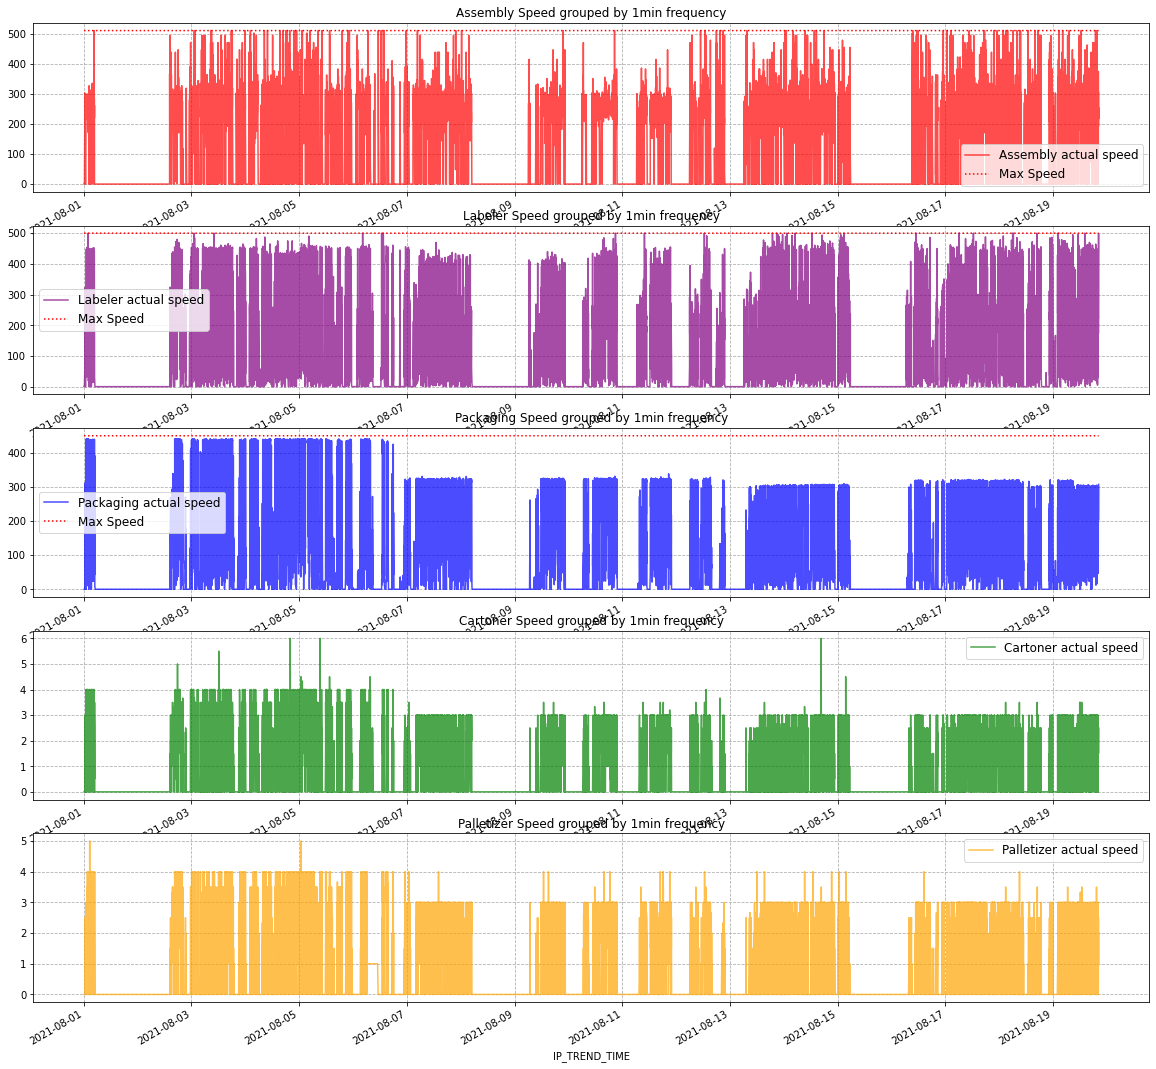

In [15]:
freq='1min'
group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('IP_TREND_TIME', inplace=True)

# machines = group.Machine.unique()
# control the order of the machines
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    if max(group['Max_Speed'][group.Machine == x]) > 0:
        group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed grouped by {} frequency'.format(x, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

In [14]:
# max speed for each our
freq=['1h','30min','10min','1m']
for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].max().unstack()
    print('\nMax Speeds by {}\n'.format(f), round(max_hours.describe(),2))


Max Speeds by 1h
 Machine  Assembly  Cartoner  Labeler  Packaging  Palletizer
count      453.00    453.00   453.00     453.00      453.00
mean       360.55      2.31   345.40     248.17        2.28
std        233.94      1.71   222.89     176.52        1.65
min          0.00      0.00     0.00       0.00        0.00
25%          0.00      0.00     0.00       0.00        0.00
50%        512.00      3.00   500.00     333.00        3.00
75%        512.00      3.00   500.00     357.00        4.00
max        512.00      6.00   500.00     456.00        5.00

Max Speeds by 30min
 Machine  Assembly  Cartoner  Labeler  Packaging  Palletizer
count      905.00    905.00   905.00     905.00      905.00
mean       328.40      2.01   316.57     223.36        1.99
std        245.54      1.70   230.07     179.58        1.66
min          0.00      0.00     0.00       0.00        0.00
25%          0.00      0.00     0.00       0.00        0.00
50%        512.00      3.00   470.00     318.00        3.00

<AxesSubplot:title={'center':'np.percentile(packaging.IP_TREND_VALUE, 25)'}, xlabel='IP_TREND_TIME'>

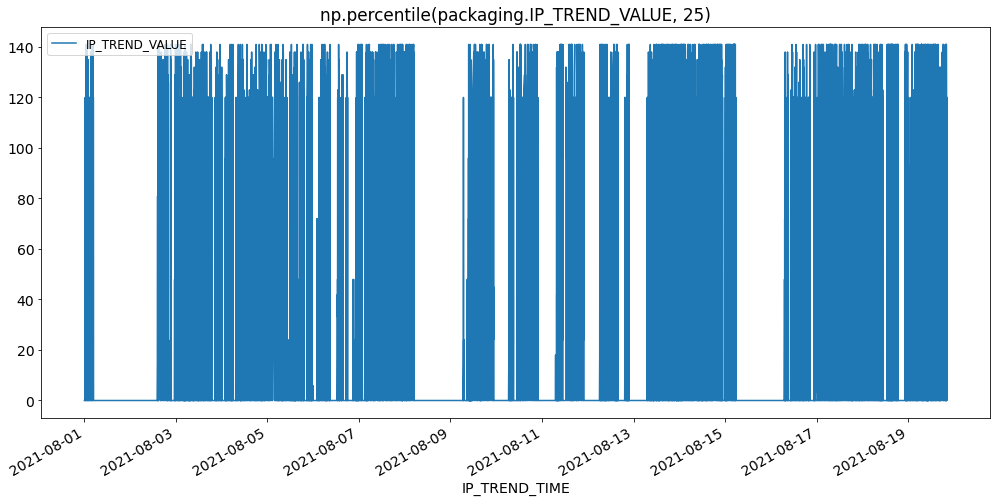

In [125]:
# get the rows for packaging where the speed is < 25% percentile
packaging = df_speed[['Machine','IP_TREND_VALUE']][df_speed.Machine == 'Packaging']
packaging[packaging.IP_TREND_VALUE < np.percentile(packaging.IP_TREND_VALUE, 25)].plot(figsize=(17,8), title='np.percentile(packaging.IP_TREND_VALUE, 25)')


<AxesSubplot:title={'center':'np.percentile(packaging.IP_TREND_VALUE, 75)'}, xlabel='IP_TREND_TIME'>

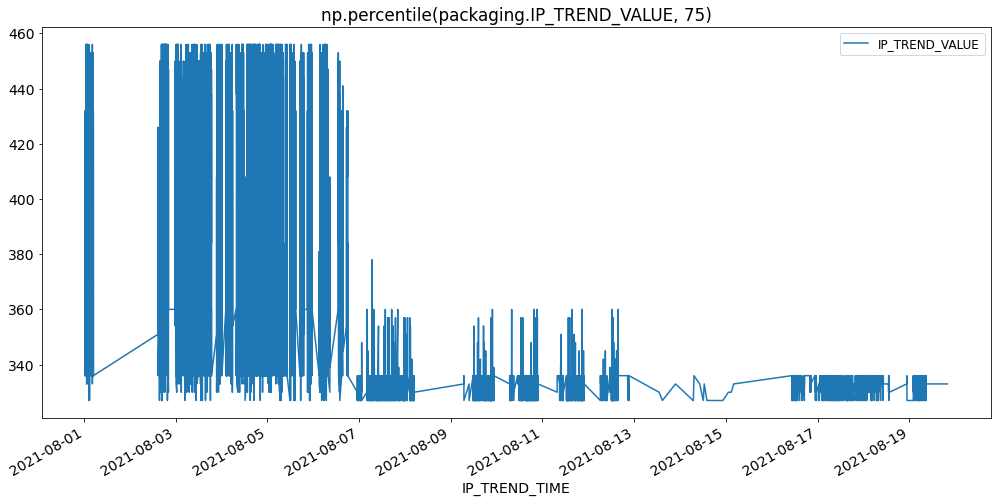

In [126]:
packaging[packaging.IP_TREND_VALUE > np.percentile(packaging.IP_TREND_VALUE, 75)].plot(figsize=(17,8), title='np.percentile(packaging.IP_TREND_VALUE, 75)')

In [22]:
filename = 'AL6_speed.xlsx'
folder = 'IP21'
path = os.path.join(dir_local, folder, filename)
df_speed.to_excel(path)
